# GOAL: This notebook contains all the proceedires and code required to:
1. Load and view Microscene images.
2. Convert raw microscene data to reflectance data, and save the reflectance image in the same location as the origonal file with '_ref' appended to the filename.

# In future notebooks, we will:
3. Buils ROIs for the plants in the microscene image(s).
4. Exctract spectra from these regions to a spectral library file.
5. Build, train, test and save classification\detection models.
6. Load spectral libraries from multiple microscene collects.
7. Build, train, test and save classification\detection models from these multi-collect libraries.
8. Apply these models to Microscene images and rigorously evaluate accuracy.
8. Apply these models to UAS hyperspectral images and rigorously evaluate accuracy.



Locations that the user smay need to change or verify will be annoted by comments like:

<<<=============================== You need to modify these to be the directory for the image you are working on ===============================>>>>

--- Code to be modified or checked here ---

<<<=============================================================================================================================================>>>>

# Part 0. Imports and data structures

<span style="color: red">You will need to change the dir names in the locations below.</span>

In [1]:
# common imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import numpy as np
import os
# specific required imports
import spectral # for worinking with hyperspectral images and libraries
import pickle # for saving and loading data
import importlib # for reloading (importing a package after you modify it without having to restart the kernel)
import hyperspectral_gta_data as hsi_data # for importing \ sharing data
# imports from local files
from hsiViewer import hsi_viewer_array as hva
import microscene_functions as msf

# set the directory containing the image(s)

# <<<=============================== You need to modify these to be the directory for the image you are working on ===============================>>>>
dir = 'C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00' 
dir_dark = 'C:/spectral_data/UPWINS/Allied_02_14_2024/100040__dark_2015_06_04_18_02_27' 
# <<<=============================================================================================================================================>>>>

In [2]:
# data sctructures - see: https://www.w3schools.com/python/python_classes.asp

class file_names:
    '''
    This class contains the filenames of the files of each type in the selected directories. 
    The supported classes are:
    - .JPG, typically high-resoluion RGB color image from a camera or GoPro, etc.
    - .png, typically an RGB color image created by the Headwall software when the hyperspectral image is captured.
    - .hdr, a header file (a text file) containing the metadata for a hyperspectral image.
    - _dark.hdr, a header file (a text file) containing the metadata for a hyperspectral 'dark' image.
    NOTES: 
    1. A dark image is an image that was acquired with the lenscap on. It will be subtracted from the hyperspectral image before processing. 
    For each collection there should be a seperate folder with the dark image, collected imedieately before the hyperspectral image.
    2. This class has methods to search for files in the provided directories.  If no file is present for a given type, the list of fnames for that type will be ['None'].
    '''
    def __init__(self, dir, dir_dark):
        '''Lists to hold the filenames for each type of file.'''
        self.dir =dir
        self.dir_dark = dir_dark        
        self.jpg = []
        self.png = []
        self.hdr = []
        self.dark_hdr= []

    def find_files(self):
        '''This method seaches the given folders and searches for files of each type.'''
        # JPG images (usually from a camera or go pro)
        for file in os.listdir(self.dir):
            if file.endswith(".JPG"):
                fnames.jpg.append(os.path.join(dir, file))     
        if len(fnames.jpg)==0:
            fnames.jpg.append('None')   
            
        # png images (usually auto-created from the hyperspectral)
        for file in os.listdir(self.dir):
            if file.endswith(".png"):
                fnames.png.append(os.path.join(dir, file))        
        if len(fnames.png)==0:
            fnames.png.append('None')   
              
        # hdr files (header files)
        for file in os.listdir(self.dir):
            if file.endswith(".hdr"):
                fnames.hdr.append(os.path.join(dir, file))  
        if len(fnames.hdr)==0:
            fnames.hdr.append('None')   
            
        # dark hdr files (header files for dark images)
        for file in os.listdir(self.dir_dark):
            if file.endswith(".hdr"):
                fnames.dark_hdr.append(os.path.join(dir_dark, file))  
        if len(fnames.dark_hdr)==0:
            fnames.dark_hdr.append('None')   
    
    def print_all(self):
        '''This method prints all the filenames for each file type.'''
        print('JPG Images:')
        for fname in self.jpg:
            print('    '+fname)
        print('png Images:')
        for fname in self.png:
            print('    '+fname)
        print('hdr files:')
        for fname in self.hdr:
            print('    '+fname)
        print('dark hdr files:')
        for fname in self.dark_hdr:
            print('    '+fname)

# Part 1. Loading dark image, hyperspectral image, and high-res image.

In [3]:
# get a list of all jpg images and header files (one header for each hyperspectral image in the image directory)
# the results will be saved in an instance of the file_names structure

# create an instance of the file_names class
fnames = file_names(dir, dir_dark)   
fnames.find_files()         
fnames.print_all()        

JPG Images:
    None
png Images:
    C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0.png
hdr files:
    C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0.hdr
    C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0_ref.hdr
dark hdr files:
    C:/spectral_data/UPWINS/Allied_02_14_2024/100040__dark_2015_06_04_18_02_27\raw_0.hdr


<span style="color: red">You will need to verify that the filenames below are correct.</span>

In [4]:
# here are the filenames located by the search
# <<<=============================== You need to check that the filenames below are correct. ===============================>>>>
fname_hres_jpg = fnames.jpg[0] 
fname_png = fnames.png[0] 
fname_dark_hdr = fnames.dark_hdr[0]  
fname_dark = fname_dark_hdr[:-4] # usually same as header fname but without the .hdr exenstion
fname_im_hdr = fnames.hdr[0] 
fname_im = fname_im_hdr[:-4]# usually same as header fname but without the .hdr exenstion
# <<<========================================================================================================================>>>>
print(f'fname_hres_jpg: {fname_hres_jpg}')
print(f'fname_png: {fname_png}')
print(f'fname_dark_hdr: {fname_dark_hdr}')
print(f'fname_dark: {fname_dark}')
print(f'fname_im_hdr: {fname_im_hdr}')
print(f'fname_im: {fname_im}')


fname_hres_jpg: None
fname_png: C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0.png
fname_dark_hdr: C:/spectral_data/UPWINS/Allied_02_14_2024/100040__dark_2015_06_04_18_02_27\raw_0.hdr
fname_dark: C:/spectral_data/UPWINS/Allied_02_14_2024/100040__dark_2015_06_04_18_02_27\raw_0
fname_im_hdr: C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0.hdr
fname_im: C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0


# Part 2. Choose the bounds to crop the image so that:
- the upper (or lower) portion is the white reference square
- the white reference square extends the full width of the image after cropping

<span style="color: red">You will need to modify the crop_rows and crop_cols to create a good crop for your image.</span>

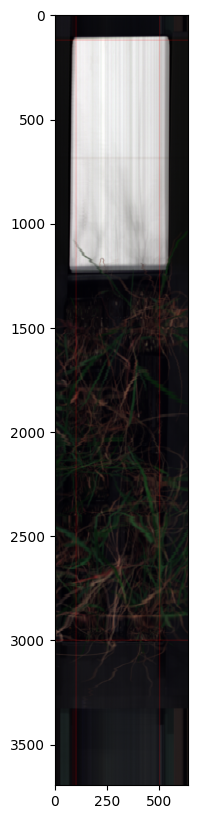

In [5]:
# Choose rows and columns to define a crop of the image
# The cropped image should:
#    - the upper (or lower) portion is the white reference square
#    - the white reference square extends the full width of the image after cropping

# crop lines:
# <<<=============================== Modify the crop range to match your image. ===============================>>>>
crop_rows = [120,3000] 
crop_cols = [100,500] 
# <<<==========================================================================================================>>>>

# read the image into a numpy array
img = mpimg.imread(fname_png)
# creatre a red box on the image to show the crop area
for c in crop_cols:
    img[:,c,0] = 1.0
    img[:,c,1] = 0
    img[:,c,2] = 0
for r in crop_rows:
    img[r,:,0] = 1.0
    img[r,:,1] = 0
    img[r,:,2] = 0
# show the image with crop lines
plt.figure(figsize=(10,10)) 
plt.imshow(img)
plt.show()



# Part 3. Extract the white reference area (to use to convert the image to reflectance)

<span style="color: red">You will need to modify the rows for your white reference in your iamge to match your image.</span>

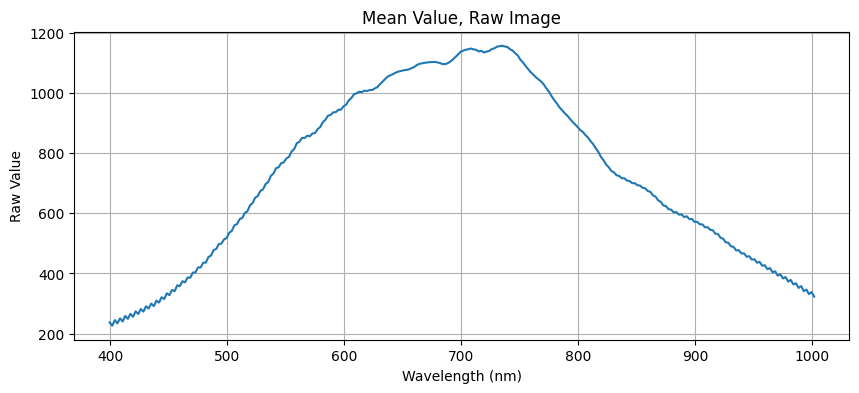

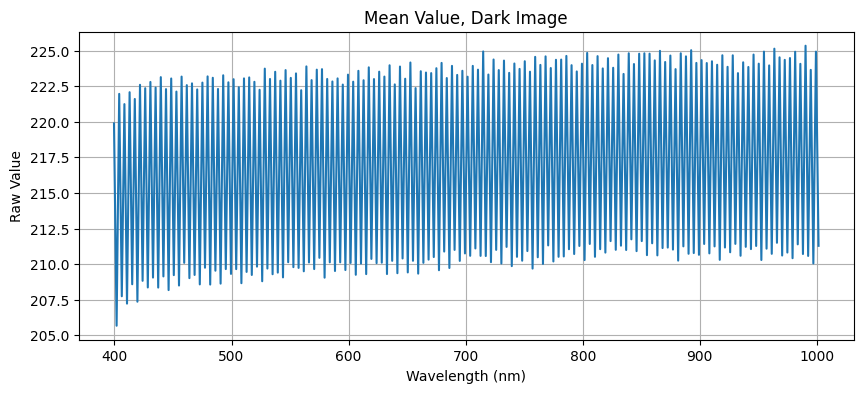

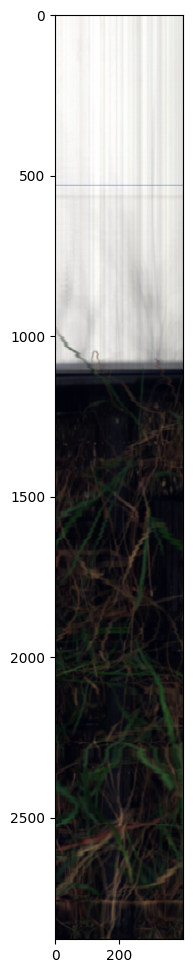

Origonial shape of im_igm.Arr = (3696, 640, 272)
Shape of im_igm.Arr after croppping = (2880, 400, 272)


In [6]:
# crop the hyperspectral image based on your drop ranges above
importlib.reload(msf)
# <<<=============================== Modify the rows for your white reference in your iamge to match your image. ===============================>>>>
white_ref_rows = [0,530] 
# <<<===========================================================================================================================================>>>>


# Open the image and read into an array
im = spectral.envi.open(fname_im_hdr, fname_im)
im.wl = np.asarray(im.bands.centers)
im.Arr = im.load()

# plot the mean raw measured value
image_mean = np.mean(np.mean(im.Arr, axis=0), axis=0)
plt.figure(figsize=(10,4))
plt.plot(im.wl, image_mean)
plt.title('Mean Value, Raw Image')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Raw Value')
plt.grid(True)
plt.show()


# Open the dark image and read into an array
im_dark = spectral.envi.open(fname_dark_hdr, fname_dark)
im_dark.wl = np.asarray(im_dark.bands.centers)
im_dark.Arr = im_dark.load()

# plot the mean raw measured dark value
image_dark_mean = np.mean(np.mean(im_dark.Arr, axis=0), axis=0)
plt.figure(figsize=(10,4))
plt.plot(im.wl, image_dark_mean)
plt.title('Mean Value, Dark Image')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Raw Value')
plt.grid(True)
plt.show()


# crop the image
imArr_cropped = im.Arr[crop_rows[0]:crop_rows[1], crop_cols[0]:crop_cols[1], :]
im.nr, im.nc, im.nb =imArr_cropped.shape

# Create the RGB with blue lines bounding the white refernce area
im_RGB = msf.make_rgb(imArr_cropped, im.wl)
for r in white_ref_rows:
    im_RGB[r,:,0] = 0
    im_RGB[r,:,1] = 0
    im_RGB[r,:,2] = 1.0
    
plt.figure(figsize=(12, 12)) 
plt.imshow(im_RGB)
plt.show()

print(f'Origonial shape of im_igm.Arr = {im.Arr.shape}')
print(f'Shape of im_igm.Arr after croppping = {imArr_cropped.shape}')

In [7]:
importlib.reload(hva)
hva.viewer(im.Arr, im.wl)

Spectra from White Reference, Raw Image (copy-paste from hsi_viewer)

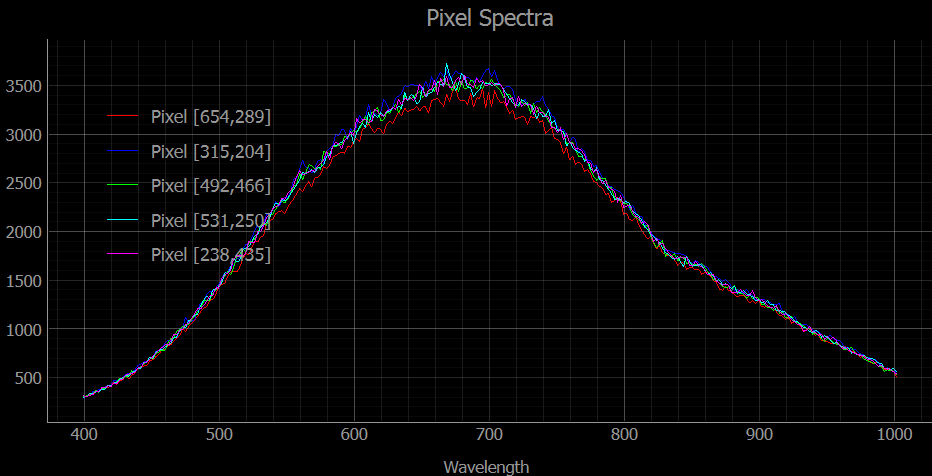

Spectral from healthy veg, raw image (copy-paste from hsi_viewer)

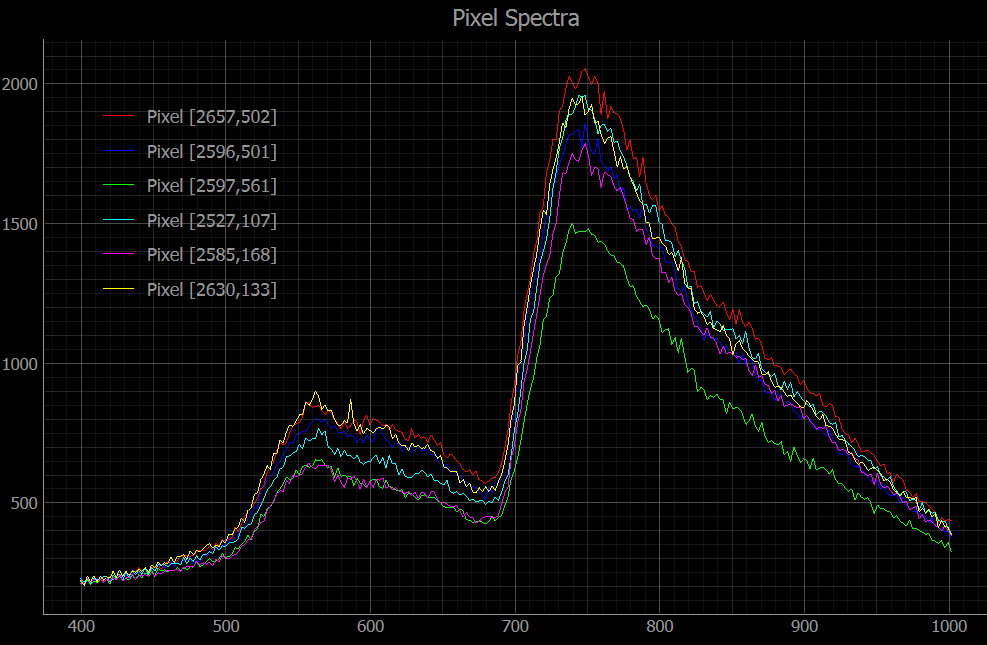

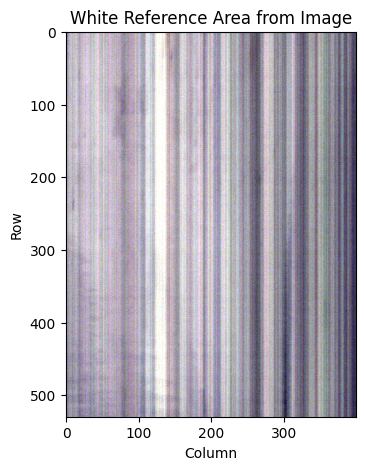

In [8]:
# create the white reference region from the inage
im_wr = imArr_cropped[white_ref_rows[0]:white_ref_rows[1], :, :]
#im_wr[:,20,:] = 10000 # use these to check the arrangement of the columns and bands in the plots
#im_wr[:,:,100] = 10000 # use these to check the arrangement of the columns and bands in the plots
im_wr_RGB = msf.make_rgb(im_wr, im.wl)    
plt.figure(figsize=(5,5)) 
plt.imshow(im_wr_RGB)
plt.title('White Reference Area from Image')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

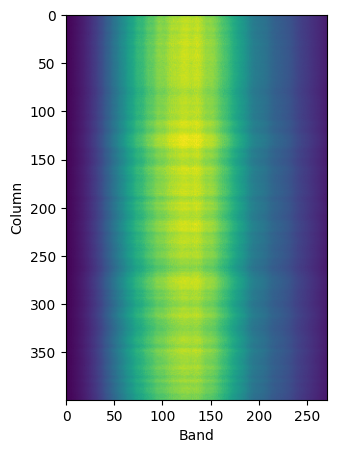

In [9]:
# image of Focal Plane Array
im_FPA = np.mean(im_wr, axis=0)
plt.figure(figsize=(5,5)) 
plt.imshow(im_FPA)
plt.xlabel('Band')
plt.ylabel('Column')
plt.show()

In [10]:
# convert to reflectance
im_ref = np.zeros((im.nr, im.nc, im.nb))
for c in range(im.nc):
    for b in range(im.nb):
        im_ref[:,c,b] = np.squeeze(    (imArr_cropped[:,c,b]-image_dark_mean[b])   /   (im_FPA[c,b]-image_dark_mean[b])    )

C:\Users\wb8by\AppData\Local\Temp\ipykernel_17452\1359392604.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  im_ref[:,c,b] = np.squeeze(    (imArr_cropped[:,c,b]-image_dark_mean[b])   /   (im_FPA[c,b]-image_dark_mean[b])    )


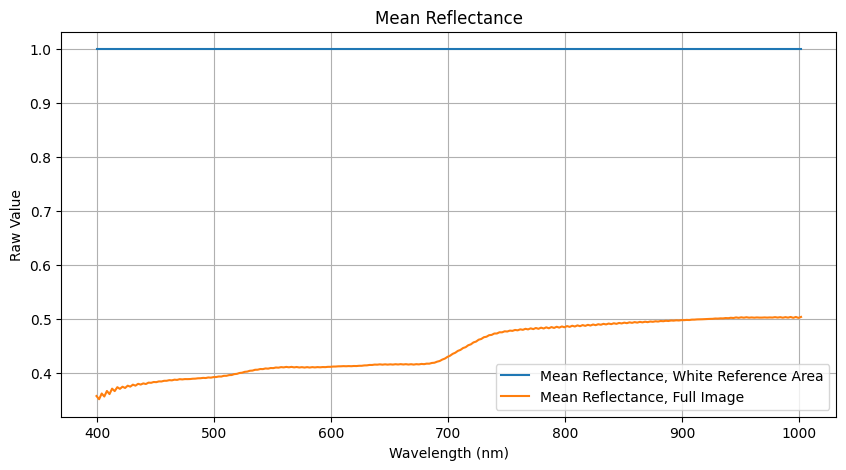

In [11]:
# plot the mean reflectance
# compute mean refleactance of white reference area
im_ref_wr = im_ref[white_ref_rows[0]:white_ref_rows[1], :, :]
im_ref_wr_mean = np.mean(np.mean(im_ref_wr, axis=0), axis=0)

# compute mean reflectance of full image
im_ref_mean = np.mean(np.mean(im_ref, axis=0), axis=0)
plt.figure(figsize=(10,5))
plt.plot(im.wl, im_ref_wr_mean, label='Mean Reflectance, White Reference Area')
plt.plot(im.wl, im_ref_mean, label='Mean Reflectance, Full Image')
plt.title('Mean Reflectance')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Raw Value')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
importlib.reload(hva)
hva.viewer(im_ref, im.wl)

Pixels on White Reference: (copy-paste from hsi_viewer)

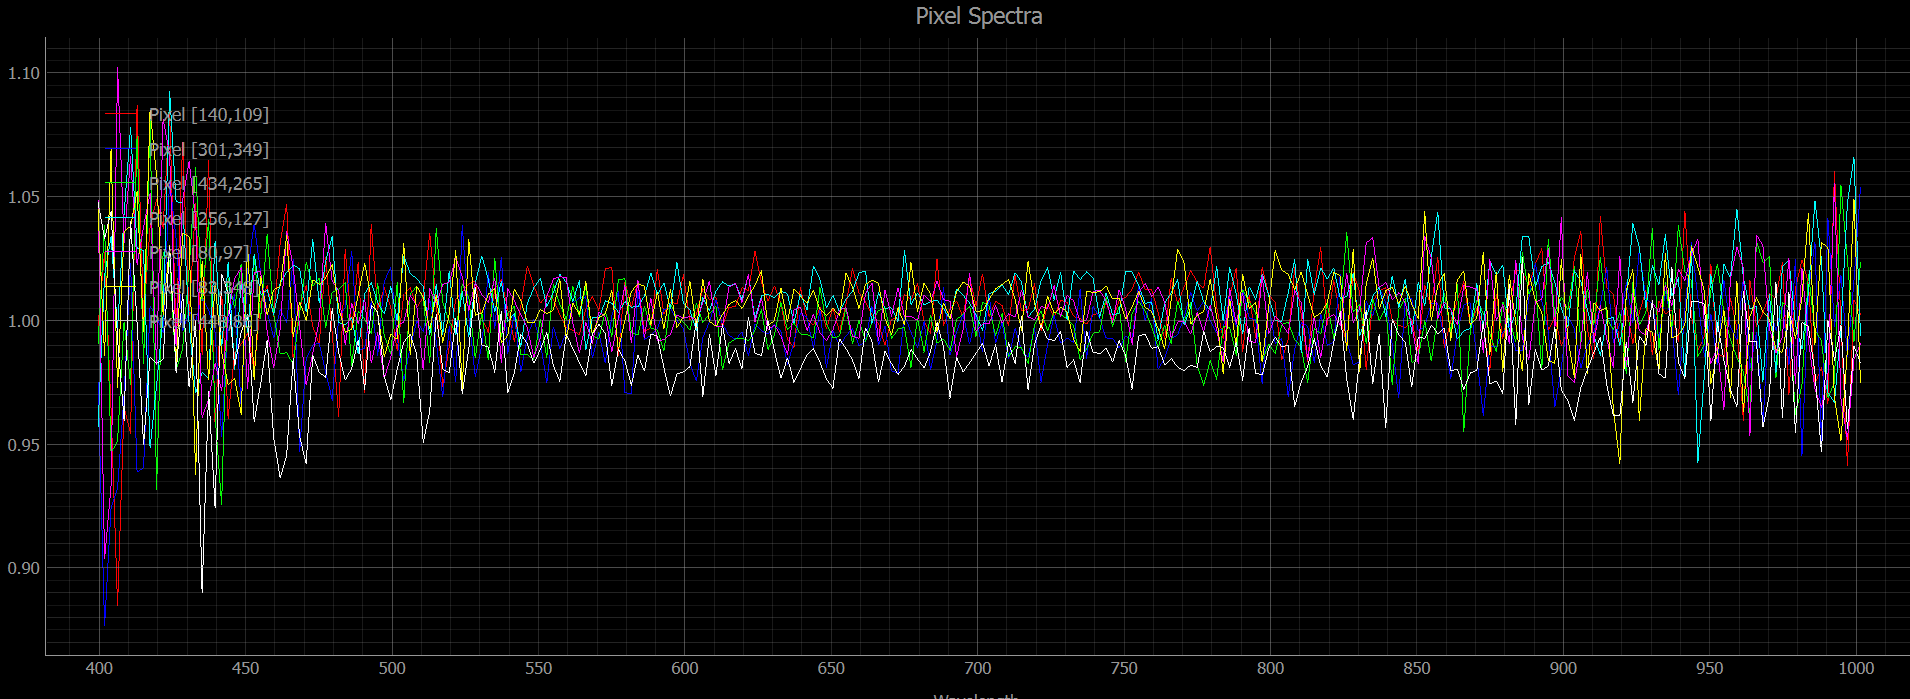

Pixels on healthy veg: (copy-paste from hsi_viewer)

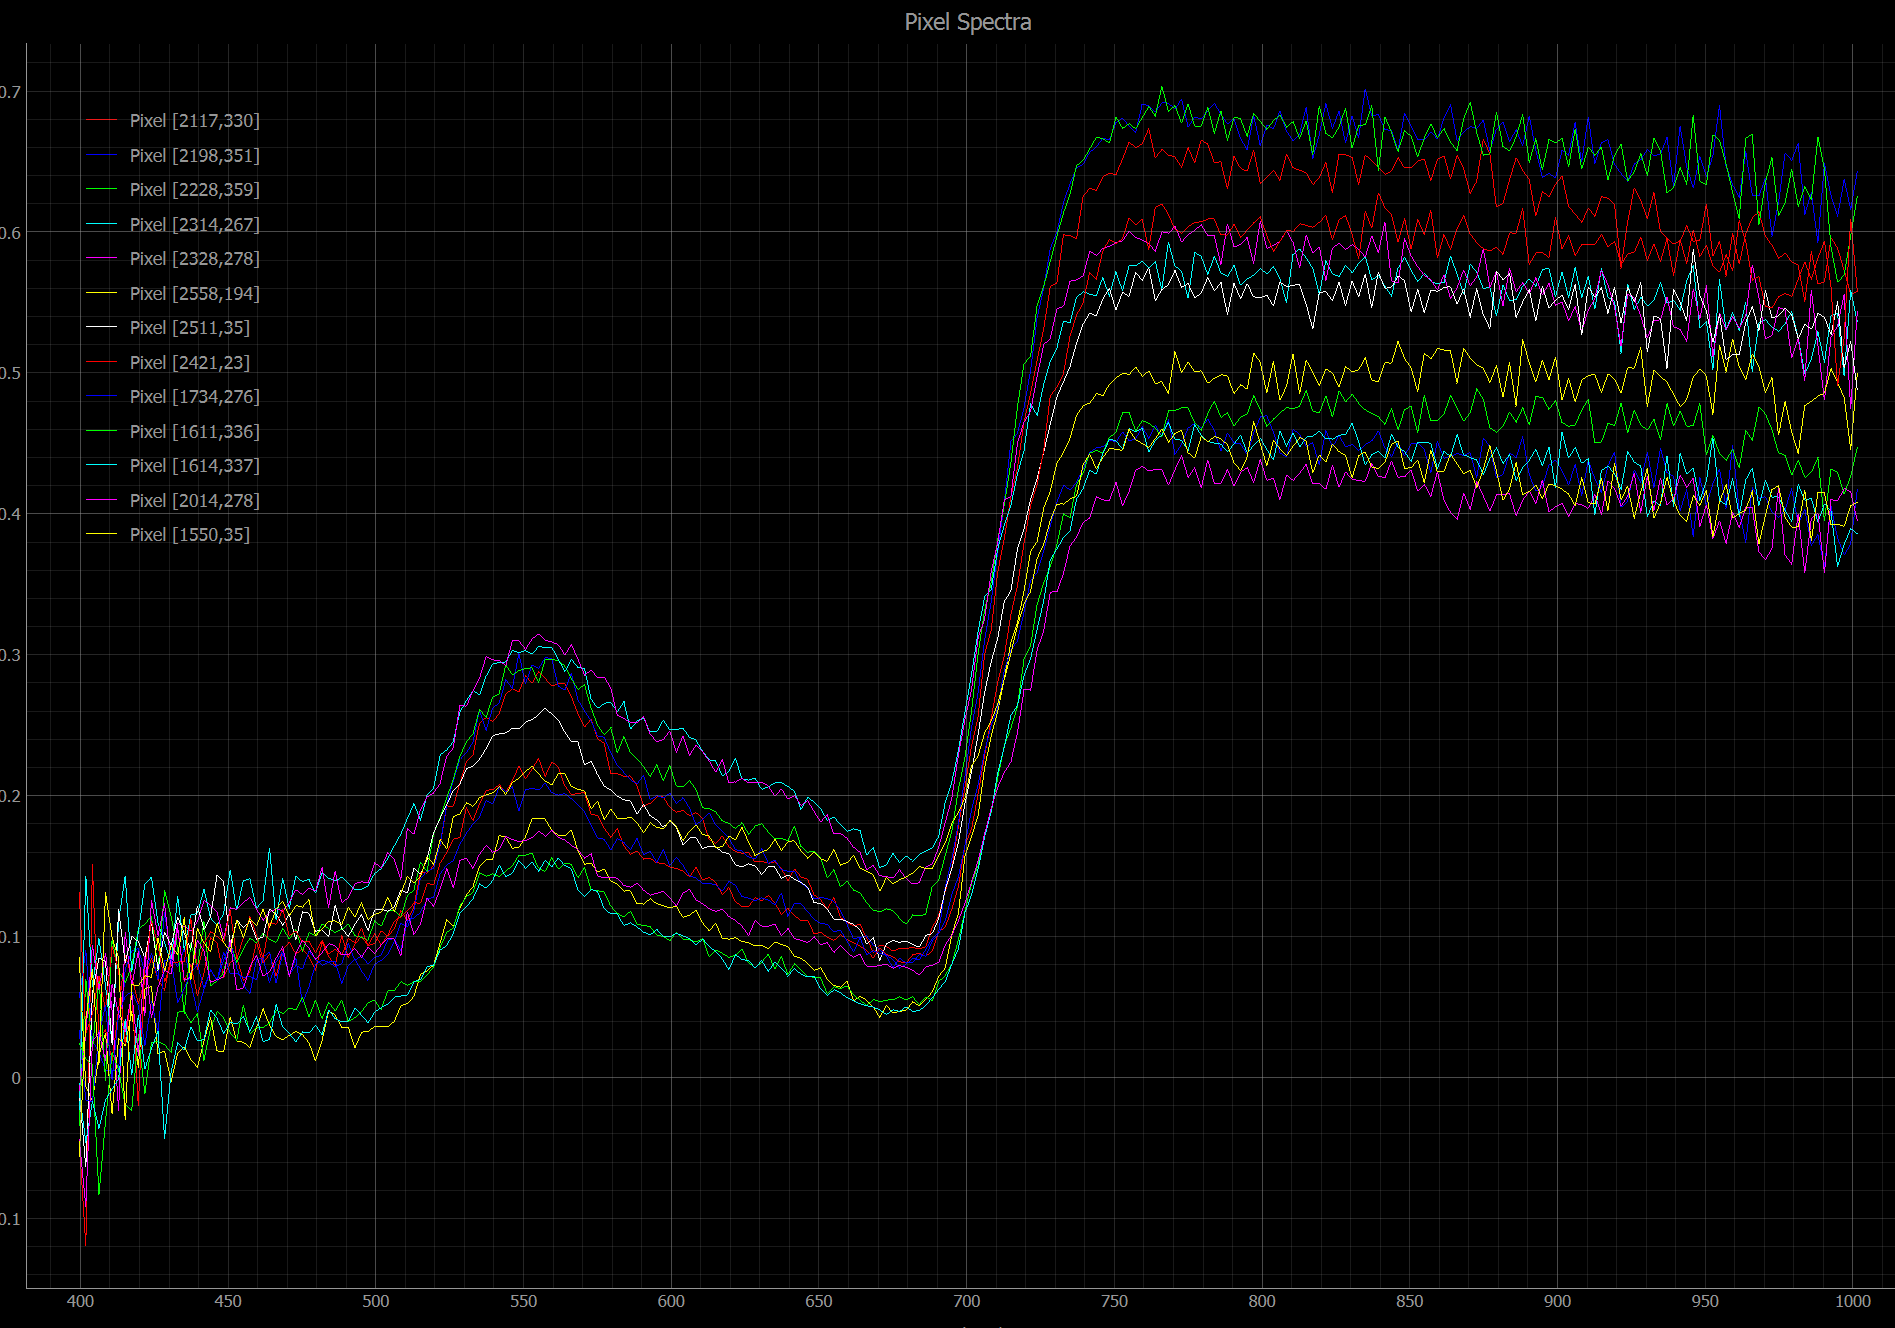

# Part 6. Save reflectance image

In [13]:
metadata = im.metadata
metadata['lines'] = im_ref.shape[0]
metadata['samples'] = im_ref.shape[1]
# create the structure for the reflectance image
spectral.envi.save_image(fname_im+'_ref'+'.hdr',im_ref.astype('float32'),
    metadata=metadata,
    ext='',
    force=True) 
print(fname_im+'_ref'+'.hdr')

C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0_ref.hdr
